In [1]:
import glob

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import glob

In [2]:
data = pd.read_csv("../data/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")

In [3]:
data[data["study_id"] == 4003253]

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


## Per study:
### 1- Map coords for sagittal (x, y)
### 2- Map coords for axial (y, z)
### 3 Extrapolate the y for axial and z for sagittal from the slice metadata
### 4 Add a buffer 20 px from min and max for each, aggregated per joint

In [4]:
base_path = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
study = 4003253
series = 702807833  #T2STIR for canal stenosis
instance = 9
file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_slice = pydicom.dcmread(file)
data_slice

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.9
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.9
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223713.422388'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.8'
(0018, 5100) Patient Position                   

In [5]:
import torch


# !TODO: Move to util func
def show_mid_slices(img4d):
    if torch.is_tensor(img4d):
        try:
            img4d = img4d.detach().cpu().numpy()
        except Exception as e:
            pass

    for i in range(len(img4d)):
        img3d = img4d[i]
        img_shape = img3d.shape

        a1 = plt.subplot(3, 3, i * 3 + 1)
        a1.imshow(img3d[:, :, img_shape[2] // 2], cmap="hot")
        a1.grid(None)

        a2 = plt.subplot(3, 3, i * 3 + 2)
        a2.imshow(img3d[:, img_shape[1] // 2, :], cmap="hot")
        a2.grid(None)

        a3 = plt.subplot(3, 3, i * 3 + 3)
        a3.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="hot")
        a3.grid(None)

    plt.show()

In [6]:
data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

In [7]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
def get_sagittal_bounding_boxes(series_data):
    sagittal_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            sagittal_coords.append([row["level"], i, row["y"], row["x"]])

    sagittal_coords = pd.DataFrame(sagittal_coords, columns=("level", "x", "y", "z"))
    sagittal_coords_groups = sagittal_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    sagittal_coords_groups["x_s"] = sagittal_coords_groups[("x", "min")].values
    sagittal_coords_groups["x_e"] = sagittal_coords_groups[("x", "max")].values
    sagittal_coords_groups["y_s"] = sagittal_coords_groups[("y", "min")].values - 20
    sagittal_coords_groups["y_e"] = sagittal_coords_groups[("y", "max")].values + 20
    sagittal_coords_groups["z_s"] = sagittal_coords_groups[("z", "min")].values - 20
    sagittal_coords_groups["z_e"] = sagittal_coords_groups[("z", "max")].values + 20

    return sagittal_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]

In [9]:
get_sagittal_bounding_boxes(data_for_series)

,x_s,x_e,y_s,y_e,z_s,z_e
,,,,,,
level,,,,,,
L1/L2,8,8,207.964602,247.964602,302.831858,342.831858
L2/L3,8,8,275.714286,315.714286,300.571429,340.571429
L3/L4,8,8,351.818182,391.818182,303.030303,343.030303
L4/L5,8,8,407.327434,447.327434,315.292035,355.292035
L5/S1,8,8,463.964602,503.964602,333.415929,373.415929


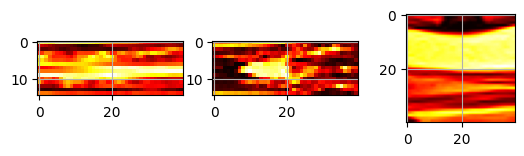

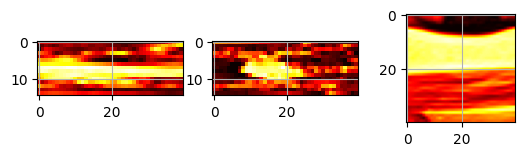

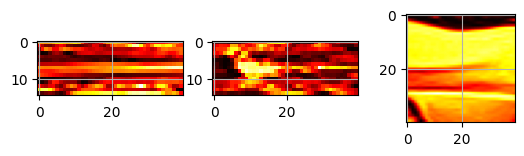

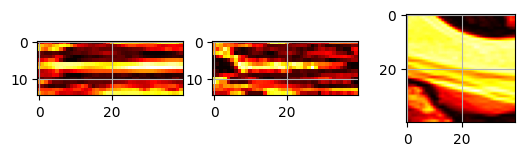

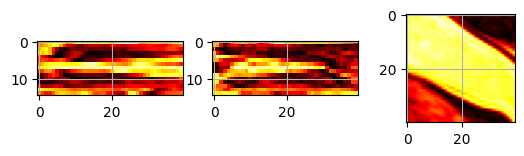

In [10]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[:, y_s:y_e, z_s:z_e], 0))

In [11]:
series = 1054713880  # T1 for foraminal narrowing
instance = 4

file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

# 5. Volume cube detection will be on low definition volumes
# 6. And the diagnosis inference will be based on the full res using the coordinates extracted previously

In [12]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

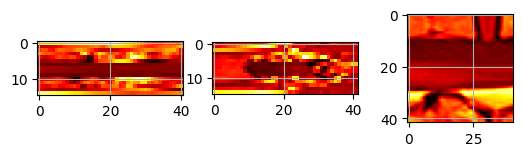

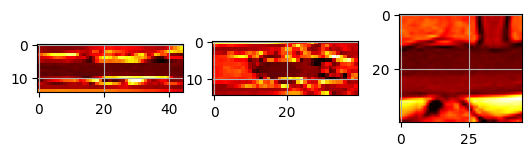

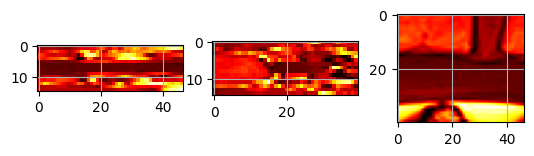

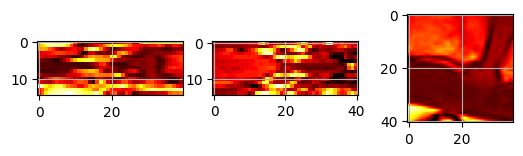

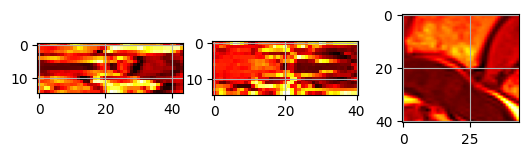

In [13]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[:, y_s:y_e, z_s:z_e], 0))

In [14]:
def get_sagittal_vol_masks(volume, series_data):
    ret = []

    bounding_boxes = get_sagittal_bounding_boxes(series_data)
    for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        mask = np.zeros(volume.shape)
        # Don't chop x for sagittal
        mask[:, y_s:y_e, z_s:z_e] = 1
        ret.append(mask)

    return ret

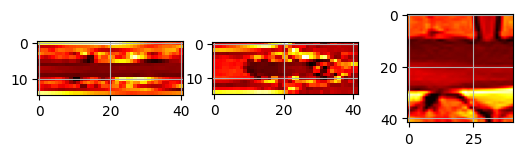

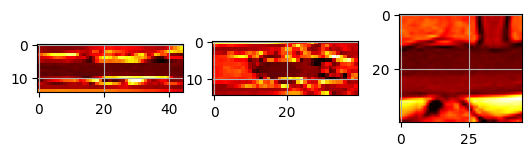

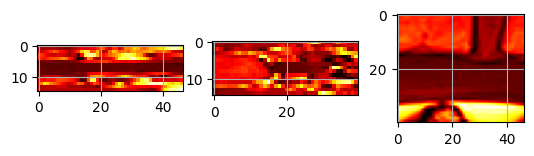

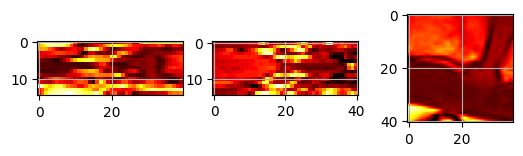

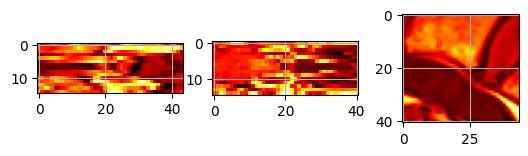

In [15]:
masks = get_sagittal_vol_masks(series_volume, data_for_series)
for mask in masks:
    masked = series_volume * mask

    coords = np.argwhere(masked)
    x_min, y_min, z_min = coords.min(axis=0)
    x_max, y_max, z_max = coords.max(axis=0)
    cropped = masked[x_min:x_max + 1, y_min:y_max + 1, z_min:z_max + 1]

    show_mid_slices(np.expand_dims(cropped, 0))

In [16]:
def get_sagittal_vol_segments(volume, series_data):
    segmentation = np.zeros(volume.shape)

    bounding_boxes = get_sagittal_bounding_boxes(series_data)
    for level_id, level in enumerate(["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]):
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        # Don't chop x for sagittal
        segmentation[:, y_s:y_e, z_s:z_e] = level_id + 1

    return segmentation

In [17]:
import torchio as tio

test_subject = tio.Subject(
    one_image=tio.ScalarImage(tensor=np.expand_dims(series_volume, 0)),
    a_segmentation=tio.LabelMap(tensor=np.expand_dims(get_sagittal_vol_segments(series_volume, data_for_series), 0)),
    study_id="test",
    series_id="es"
)

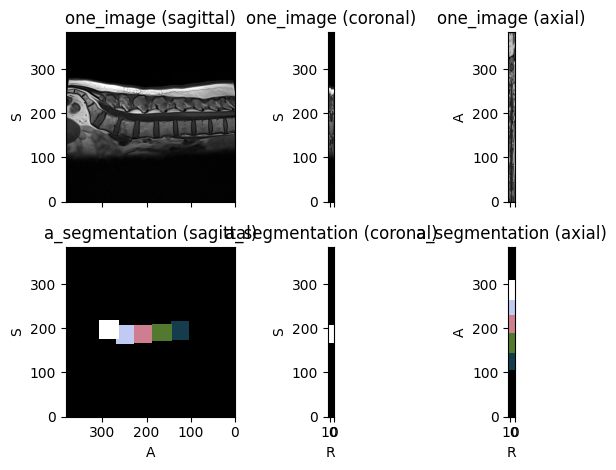

In [18]:
test_subject.plot()

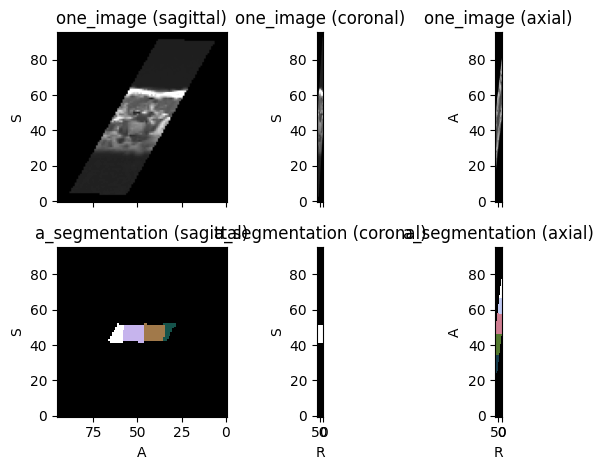

In [19]:
transform_3d = tio.Compose([
    tio.Resize((96, 96, 96), image_interpolation="bspline"),
    tio.RandomAffine(p=1),
])

transform_3d(test_subject).plot()

In [20]:
series = 2448190387

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]
series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")


def get_axial_bounding_boxes(series_data):
    axial_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            axial_coords.append([row["level"], i, row["y"], row["x"]])

    axial_coords = pd.DataFrame(axial_coords, columns=("level", "x", "y", "z"))
    axial_coords_groups = axial_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    axial_coords_groups["x_s"] = axial_coords_groups[("x", "min")].values - 3
    axial_coords_groups["x_e"] = axial_coords_groups[("x", "max")].values + 3
    axial_coords_groups["y_s"] = axial_coords_groups[("y", "min")].values - 20
    axial_coords_groups["y_e"] = axial_coords_groups[("y", "max")].values + 20
    axial_coords_groups["z_s"] = axial_coords_groups[("z", "min")].values - 20
    axial_coords_groups["z_e"] = axial_coords_groups[("z", "max")].values + 20

    return axial_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]


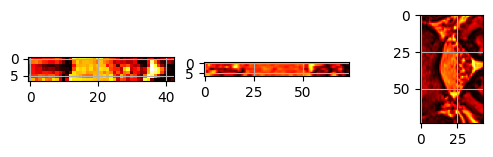

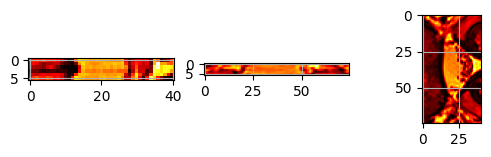

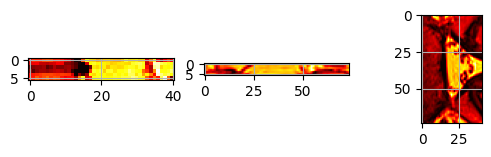

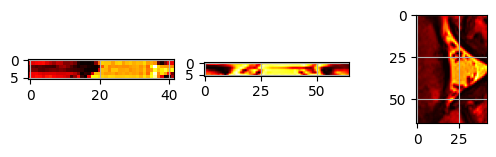

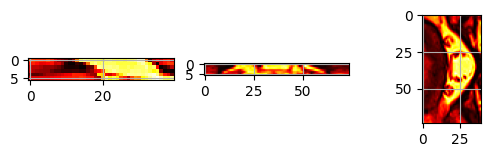

In [21]:
bounding_boxes = get_axial_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[x_s:x_e, y_s:y_e, z_s:z_e], 0))

In [22]:
def get_axial_vol_segments(volume, series_data):
    ret = []

    bounding_boxes = get_axial_bounding_boxes(series_data)
    for level_id, level in enumerate(["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]):
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        segmentation = np.zeros(volume.shape)
        segmentation[x_s:x_e, y_s:y_e, z_s:z_e] = 1
        ret.append(segmentation)

    return np.array(ret)


In [23]:
test_subject_2 = tio.Subject(
    one_image=tio.ScalarImage(tensor=np.expand_dims(series_volume, 0)),
    a_segmentation=tio.LabelMap(tensor=get_axial_vol_segments(series_volume, data_for_series)),
    study_id="test2",
    series_id="es2"
)

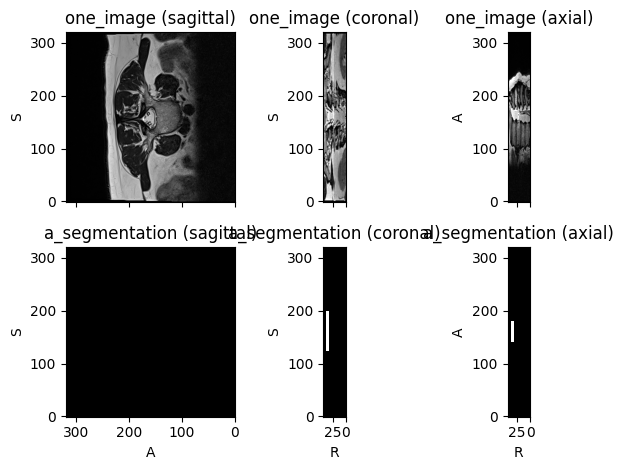

In [24]:
test_subject_2.plot()

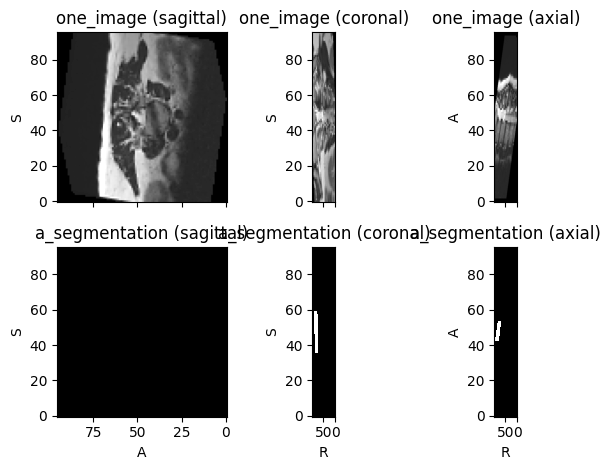

In [25]:
transform_3d(test_subject_2).plot()

In [30]:
from train_segmentation_model import *

model = UNet(n_channels=1, n_classes=5)
model = torch.load(
    "C:\\Users\\Victor\\Documents\\python-doodles\\models\\sagittal_segmentation_64_3d\\sagittal_segmentation_64_3d_23.pt").to(
    "cuda")

series = 1054713880  # T1 for foraminal narrowing
data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]
series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")
series_volume = np.repeat(np.expand_dims(series_volume, 0), repeats=2, axis=0)

test_subject_3 = tio.Subject(
    one_image=tio.ScalarImage(tensor=series_volume),
    a_segmentation=tio.LabelMap(tensor=get_sagittal_vol_segments(series_volume, data_for_series)),
    study_id="test3",
    series_id="es3"
)

inp = transform_3d(test_subject_3)
with torch.no_grad():
    out = model(inp.get_images()[0].tensor.unsqueeze(0).to("cuda"))

NameError: name 'UNet' is not defined

In [ ]:
#https://github.com/milesial/Pytorch-UNet/blob/master/train.py

In [28]:
out.shape, inp["a_segmentation"].tensor.shape

NameError: name 'out' is not defined

In [ ]:
label_test = out.squeeze(0).detach().to("cpu")[4].unsqueeze(0)
label_test_i = torch.unravel_index(label_test.argmax(), label_test.shape)

label_test_ = torch.zeros(label_test.shape)
label_test_[:,
0: label_test_i[1] + 50,
max(0, label_test_i[2] - 10): label_test_i[2] + 20,
0: label_test_i[3] + 20,
] = 1

tio.Subject(
    one_image=tio.ScalarImage(tensor=series_volume),
    a_segmentation=tio.LabelMap(tensor=label_test_),
).plot()

In [ ]:
box_pred = out.squeeze(0).detach().to("cpu")[1].unsqueeze(0)
box_pred.shape

In [ ]:
box_pred * box_pred

In [ ]:
with torch.no_grad():
    print(SegmentationLoss()(box_pred, F.sigmoid(box_pred)))
    print(F.binary_cross_entropy_with_logits(box_pred, F.sigmoid(box_pred)))
    print(SegmentationLoss().dice_loss(F.sigmoid(box_pred), F.sigmoid(box_pred)))

In [ ]:
with torch.no_grad():
    print(SegmentationLoss()(box_pred, 1 - F.sigmoid(box_pred)))
    print(F.binary_cross_entropy_with_logits(box_pred, 1 - F.sigmoid(box_pred)))
    print(SegmentationLoss().dice_loss(F.sigmoid(box_pred), 1 - F.sigmoid(box_pred)))

In [ ]:
data_for_series

In [ ]:
plt.imshow(series_volume[8], cmap="gray")

In [ ]:
points = list(zip(data_for_series["x"].values, data_for_series["y"].values))
points

In [ ]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

In [ ]:
from PIL import Image

raw_image = Image.fromarray(series_volume[8]).convert("RGB")
# mask_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
input_boxes = [[[e[0] - 100, e[1] - 20, e[0], e[1] + 30] for e in points]]

# !TODO: Use some curve fit and normal to expand into disc
input_boxes[0][-1][-1] += 20
input_boxes[0][-1][-3] += 20

input_points = [[e for e in points]]  # 2D location of a window in the image

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0])

In [ ]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# inputs = processor(raw_image, input_points=input_points, segmentation_maps=segmentation_map, return_tensors="pt").to(device)
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i + 1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()


In [ ]:
for i in range(len(masks[0])):
    show_masks_on_image(raw_image, masks[0][i], scores[:, i, :])

In [ ]:
import cv2


def get_mask_centroids(mask):
    ret = []

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        ret.append((cX, cY))

    return ret

In [ ]:
test_mask = (masks[0][0][0].numpy() * 1).astype(np.uint8)
test_mask

In [ ]:
show_points_on_image(raw_image, get_mask_centroids(test_mask))

In [ ]:
centroids = [get_mask_centroids(
    (e[0].numpy() * 1).astype(np.uint8)
) for e in masks[0]]
centroids

In [ ]:
height = (centroids[-2][0][1] - centroids[-3][0][1]) * 0.5
show_boxes_on_image(raw_image, [(centroids[-2][0][0], centroids[-2][0][1] - height,
                                centroids[-2][0][0] + 2 * height, centroids[-2][0][1] + height)])

In [ ]:
import torch
import torchvision
import segmentation_models_pytorch as smp

model_2d = smp.Unet(
        classes=5
    )
model_2d.load_state_dict(torch.load("C:\\Users\\Victor\\Documents\\python-doodles\\models\\sagittal_segmentation_512_2d\\sagittal_segmentation_512_2d_26.pt"))

In [ ]:
import pydicom
import cv2

raw_image = pydicom.read_file("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm").pixel_array
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)

model_2d.eval()
with torch.no_grad():
    masks = model_2d(torch.Tensor(raw_image).swapaxes(-1, -3).swapaxes(-1, -2).unsqueeze(0))

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

plt.imshow(masks[0][4])
plt.show()

In [ ]:
from rsna_dataloader import *
import torchvision.transforms as transforms

transform_2d_val = transforms.Compose([
    # transforms.Resize(CONFIG["img_size"]),
    transforms.Normalize(mean=0.5, std=0.5),
])

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

(trainloader, valloader, test_loader,
 trainset, valset, testset) = create_series_level_segmentation_datasets_and_loaders(TRAINING_DATA,
                                                                                    data_type="Sagittal T2/STIR",
                                                                                    transform_2d_train=transform_2d_val,
                                                                                    transform_2d_val=transform_2d_val,
                                                                                    base_path=os.path.join(
                                                                                        DATA_BASEPATH,
                                                                                        "train_images"),
                                                                                    num_workers=0,
                                                                                    split_factor=0.3,
                                                                                    batch_size=1,
                                                                                    pin_memory=False
                                                                                    )

In [ ]:
fig, ax = plt.subplots(5, 5)

for i in range(5):
    img = testset[i][0]
    mask = testset[i][1]
    for j in range(5):
        ax[i, j].imshow(img[0] + mask[j], cmap="gray")

plt.show()

In [32]:
import nibabel as nib

nii = nib.load("D:\\Users\\Victor\\Documents\\python-doodles\\data\\spine_segmentation_nnunet_v2\\segmentations\\case_0002.nii")

In [33]:
import matplotlib.pyplot as plt
import numpy as np

img = np.array(nii.dataobj)

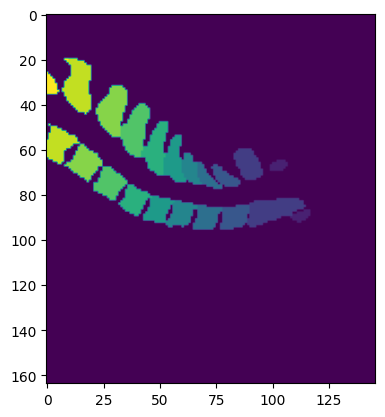

In [34]:
plt.imshow(img[len(img)//2])

In [35]:
img[len(img)//2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [36]:
nim = nib.load("D:\\Users\\Victor\\Documents\\python-doodles\\data\\lumbar-segmentation\\nii\\masks\\Img_01_Labels.nii")
label = np.array(nim.dataobj)

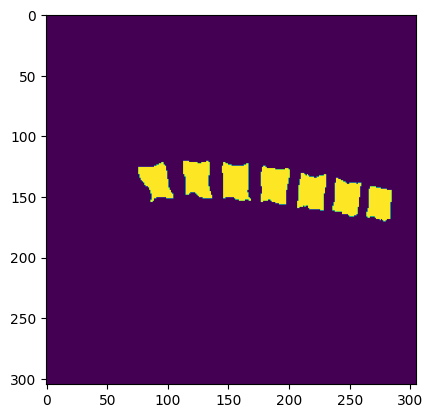

In [37]:
plt.imshow(label[25])

In [38]:
import pandas as pd

data = pd.read_csv("../data/lumbar-segmentation/dataset.csv")

In [39]:
data

,id,case,slice,image_path (nii),mask_path (nii),image_slices (png),mask_slices (png),empty
0,Case_02_Slice_0,2,0,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
1,Case_02_Slice_1,2,1,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
2,Case_02_Slice_2,2,2,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
3,Case_02_Slice_3,2,3,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
4,Case_02_Slice_4,2,4,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
...,...,...,...,...,...,...,...,...
892,Case_16_Slice_34,16,34,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
893,Case_16_Slice_35,16,35,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
894,Case_16_Slice_36,16,36,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True
895,Case_16_Slice_37,16,37,/kaggle/input/lumbar-spine-segmentation/nii/im...,/kaggle/input/lumbar-spine-segmentation/nii/ma...,/kaggle/input/lumbar-spine-segmentation/png/im...,/kaggle/input/lumbar-spine-segmentation/png/ma...,True


In [40]:
import torch
import torch.nn.functional as F
import segmentation_models_pytorch as smp

loss = smp.losses.DiceLoss(mode="multiclass")

label_test = torch.zeros((16, 16, 16))
label_test[:, 8:, :] = 1
label_test[:, 12:, :] = 2
label_test = label_test.to(torch.int64)

label_test_oh = F.one_hot(label_test, num_classes=3)
label_test_oh = label_test_oh.permute(3, 0, 1, 2)

label_test = label_test.unsqueeze(0)

label_test_oh.shape, label_test.shape

ModuleNotFoundError: No module named 'segmentation_models_pytorch'

In [ ]:
loss(label_test_oh.unsqueeze(0).to(torch.float), label_test)

In [ ]:
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False,
                          epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), F.one_hot(target, num_classes=3).permute(0,-1,1,2,3).flatten(0, 1),
                               reduce_batch_first, epsilon)

def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


In [ ]:
label_test_oh.unsqueeze(0).size()

In [ ]:
test = F.one_hot(label_test).permute(0, 4, 1, 2, 3)
test[test==1] = 2
test[test==0] = 1
test[test==2] = 1

In [ ]:
label_test.size(), label_test_oh.size()

In [ ]:
dice_loss(label_test_oh.unsqueeze(0).to(torch.float), torch.abs(1-label_test), multiclass=True)

In [ ]:
loss(label_test_oh.unsqueeze(0).to(torch.float), label_test)

In [ ]:
dice_loss(label_test_oh.unsqueeze(0).to(torch.float), test, multiclass=False)


In [66]:
from train_segmentation_model import *
import segmentation_models_pytorch_3d as smp3d

model = smp3d.Unet(
        encoder_name="efficientnet-b5",  # choose encoder, e.g. resnet34
        in_channels=1,  # model input channels (1 for gray-scale volumes, 3 for RGB, etc.)
        classes=26,  # model output channels (number of classes in your dataset)
    )
model.load_state_dict(torch.load("../models/efficientnet-b5_unet_segmentation_96_3d_per_vertebrae/efficientnet-b5_unet_segmentation_96_3d_per_vertebrae_48.pt"))

<All keys matched successfully>

In [43]:
import nibabel as nib

nii = nib.load("../data/lumbar-segmentation/nii/images/Img_04.nii")
nii_2 = nib.load("../data/spine_segmentation_nnunet_v2/volumes/case_0193.nii")

In [44]:
from rsna_dataloader import *

dii = read_study_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/8785691")

In [49]:
import torchio as tio

transform_3d_val = tio.Compose([
    tio.Resize((96, 96, 96), image_interpolation=CONFIG["interpolation"]),
    tio.RescaleIntensity(out_min_max=(0, 1)),
])
inp = torch.tensor(transform_3d_val(np.expand_dims(np.array(nii.dataobj), 0))).unsqueeze(0)
inp_2 = torch.tensor(transform_3d_val(np.expand_dims(np.array(nii_2.dataobj), 0))).unsqueeze(0)
inp_3 = torch.tensor(transform_3d_val(np.expand_dims(dii[0], 0).astype(np.float64))).unsqueeze(0)

In [67]:
model.eval()
with torch.no_grad():
    out = model(inp)
    out_2 = model(inp_2)
    out_3 = model(inp_3)

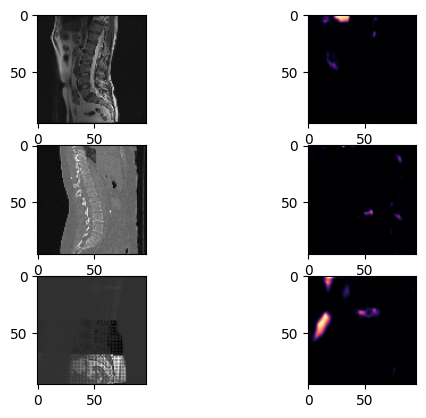

In [68]:
# out_ = F.relu(F.normalize(out))
# out_2_ = F.relu(F.normalize(out_2))
# out_3_ = F.relu(F.normalize(out_3))
out_ = F.sigmoid(out)
out_2_ = F.sigmoid(out_2)
out_3_ = F.sigmoid(out_3)

index=1

f, ax = plt.subplots(3, 2)
ax[0, 1].imshow(out_[0][index,48,:,:].detach().rot90(1), cmap="magma")
ax[1, 1].imshow(out_2_[0][index,48,:,:].detach().rot90(1), cmap="magma")
ax[2, 1].imshow(out_3_[0][index,48,:,:].detach().rot90(1), cmap="magma")

ax[0, 0].imshow(inp[0][0][48,:,:].detach().rot90(1), cmap="gray")
ax[1, 0].imshow(inp_2[0][0][48,:,:].detach().rot90(1), cmap="gray")
ax[2, 0].imshow(inp_3[0][0][48,:,:].detach().rot90(1), cmap="gray")

plt.show()


In [ ]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np

data = pydicom.read_file("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/3666319702/10.dcm").pixel_array
plt.imshow(data)

In [ ]:
plt.imshow(np.log(data + 1))